**Justin Tuyisenge - 101002**

**MSDA9223 Quiz - Data Mining and Information Retrieval**

# Market Basket Analysis for Grocery Store

This notebook performs Market Basket Analysis using Association Rules on the grocery store dataset
according to the quiz requirements:

**Task 1:** Use Association to discover patterns - Identify frequent itemsets and associations\
**Task 2:** Generate association rules ("if A, then B")\
**Task 3:** Understand customer behavior and purchasing habits\
**Task 4:** Draw actionable recommendations

## Importing required libraries

In [8]:
# Import required libraries with dependency checks
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import networkx as nx
    from mlxtend.frequent_patterns import apriori, association_rules
    import numpy as np
except ImportError as e:
    print(f"Error: Missing required library - {e}. Install using `pip install pandas mlxtend matplotlib seaborn networkx`.")
    raise SystemExit("Stopping execution due to missing dependencies.")

# Set plot style for consistent visualizations
plt.style.use('seaborn-v0_8')

## Data Loading and Preprocessing

First, we load and explore the grocery store dataset to understand its structure.

In [9]:
def load_grocery_data(file_path):
    """Load and preprocess grocery store transaction data"""
    try:
        # Read the CSV file
        df = pd.read_csv(file_path, header=None, dtype=str, encoding='utf-8')
        
        # Create list of transactions, removing empty strings and NaN values
        transactions = []
        for i in range(len(df)):
            transaction = [item.strip() for item in df.iloc[i] if pd.notna(item) and item.strip()]
            if transaction:  # Only append non-empty transactions
                transactions.append(transaction)
        
        if not transactions:
            print("Error: No valid transactions found in the dataset.")
            return None, None
        
        # Get unique items
        unique_items = sorted(set(item for transaction in transactions for item in transaction))
        
        # Display basic statistics
        total_transactions = len(transactions)
        transaction_lengths = [len(t) for t in transactions]
        avg_length = sum(transaction_lengths) / total_transactions
        
        print(f"Dataset Overview:")
        print(f"- Total Transactions: {total_transactions}")
        print(f"- Unique Items: {len(unique_items)}")
        print(f"- Average Items per Transaction: {avg_length:.2f}")
        
        return transactions, unique_items
        
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found.")
        return None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def create_transaction_matrix(transactions, unique_items):
    """Convert transactions to one-hot encoded DataFrame for Apriori algorithm"""
    try:
        # Create one-hot encoded matrix
        one_hot = []
        for transaction in transactions:
            # Initialize with zeros for all items
            transaction_dict = {item: 0 for item in unique_items}
            # Set purchased items to 1
            for item in transaction:
                if item in transaction_dict:
                    transaction_dict[item] = 1
            one_hot.append(list(transaction_dict.values()))
        
        # Convert to DataFrame with boolean type
        df = pd.DataFrame(one_hot, columns=unique_items, dtype=bool)
        print(f"Transaction matrix created: {df.shape[0]} transactions × {df.shape[1]} items")
        return df
        
    except Exception as e:
        print(f"Error creating transaction matrix: {e}")
        return None

# Load the grocery data
file_path = 'groceries.csv'
transactions, unique_items = load_grocery_data(file_path)

if transactions is None:
    raise SystemExit("Cannot proceed without data. Please check the file path and format.")

# Create transaction matrix
transaction_matrix = create_transaction_matrix(transactions, unique_items)

Dataset Overview:
- Total Transactions: 9835
- Unique Items: 169
- Average Items per Transaction: 4.41
Transaction matrix created: 9835 transactions × 169 items


## **Task 1: Use Association to Discover Patterns**
### Identify frequent itemsets and associations between different grocery items

TASK 1: DISCOVERING FREQUENT PATTERNS
Found 333 frequent itemsets with support ≥ 0.01

Frequent Itemsets by Size:
- 1-itemsets: 88
- 2-itemsets: 213
- 3-itemsets: 32

Top 10 Frequent Itemsets:
--------------------------------------------------
Support: 0.256 | Items: {whole milk}
Support: 0.193 | Items: {other vegetables}
Support: 0.184 | Items: {rolls/buns}
Support: 0.174 | Items: {soda}
Support: 0.140 | Items: {yogurt}
Support: 0.111 | Items: {bottled water}
Support: 0.109 | Items: {root vegetables}
Support: 0.105 | Items: {tropical fruit}
Support: 0.099 | Items: {shopping bags}
Support: 0.094 | Items: {sausage}


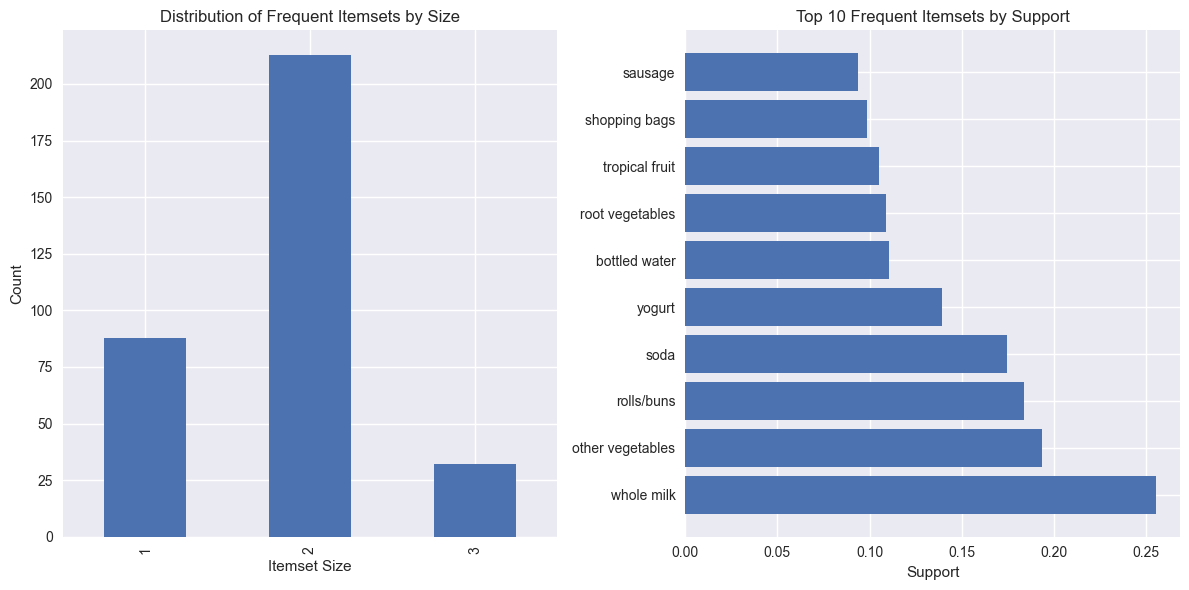

In [10]:
def discover_frequent_patterns(df, min_support=0.01):
    """
    Task 1: Discover frequent itemsets and patterns using Apriori algorithm
    """
    print("=" * 60)
    print("TASK 1: DISCOVERING FREQUENT PATTERNS")
    print("=" * 60)
    
    try:
        # Apply Apriori algorithm to find frequent itemsets
        frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, low_memory=True)
        
        if frequent_itemsets.empty:
            print(f"No frequent itemsets found with min_support={min_support}")
            return None
        
        print(f"Found {len(frequent_itemsets)} frequent itemsets with support ≥ {min_support}")
        
        # Categorize itemsets by size
        itemset_sizes = frequent_itemsets['itemsets'].apply(len)
        size_counts = itemset_sizes.value_counts().sort_index()
        
        print("\nFrequent Itemsets by Size:")
        for size, count in size_counts.items():
            print(f"- {size}-itemsets: {count}")
        
        # Display top 10 frequent itemsets
        top_itemsets = frequent_itemsets.sort_values('support', ascending=False).head(10)
        print(f"\nTop 10 Frequent Itemsets:")
        print("-" * 50)
        for idx, row in top_itemsets.iterrows():
            items = ', '.join(list(row['itemsets']))
            print(f"Support: {row['support']:.3f} | Items: {{{items}}}")
        
        # Visualize frequent itemsets
        plt.figure(figsize=(12, 6))
        
        # Plot 1: Itemset size distribution
        plt.subplot(1, 2, 1)
        size_counts.plot(kind='bar')
        plt.title('Distribution of Frequent Itemsets by Size')
        plt.xlabel('Itemset Size')
        plt.ylabel('Count')
        
        # Plot 2: Top itemsets by support
        plt.subplot(1, 2, 2)
        top_10 = frequent_itemsets.sort_values('support', ascending=False).head(10)
        top_10['itemset_str'] = top_10['itemsets'].apply(lambda x: ', '.join(list(x))[:20] + '...' if len(', '.join(list(x))) > 20 else ', '.join(list(x)))
        plt.barh(range(len(top_10)), top_10['support'])
        plt.yticks(range(len(top_10)), top_10['itemset_str'])
        plt.title('Top 10 Frequent Itemsets by Support')
        plt.xlabel('Support')
        
        plt.tight_layout()
        plt.show()
        
        return frequent_itemsets
        
    except Exception as e:
        print(f"Error in pattern discovery: {e}")
        return None

# Execute Task 1
frequent_itemsets = discover_frequent_patterns(transaction_matrix)

## **Task 2: Generate Association Rules**
### Create association rules describing relationships ("if A, then B")

TASK 2: GENERATING ASSOCIATION RULES
Generated 125 association rules with confidence ≥ 0.3

Top 15 Association Rules (sorted by lift):
--------------------------------------------------------------------------------
Rule                                     Support    Confidence   Lift    
--------------------------------------------------------------------------------
{other vegetables, citrus fruit}...      0.010      0.359        3.30    
{other vegetables, tropical frui...      0.012      0.343        3.14    
{beef} → {root vegetables}               0.017      0.331        3.04    
{citrus fruit, root vegetables} ...      0.010      0.586        3.03    
{root vegetables, tropical fruit...      0.012      0.585        3.02    
{other vegetables, whole milk} →...      0.023      0.310        2.84    
{curd, whole milk} → {yogurt}            0.010      0.385        2.76    
{rolls/buns, root vegetables} → ...      0.012      0.502        2.59    
{yogurt, root vegetables} → {oth...  

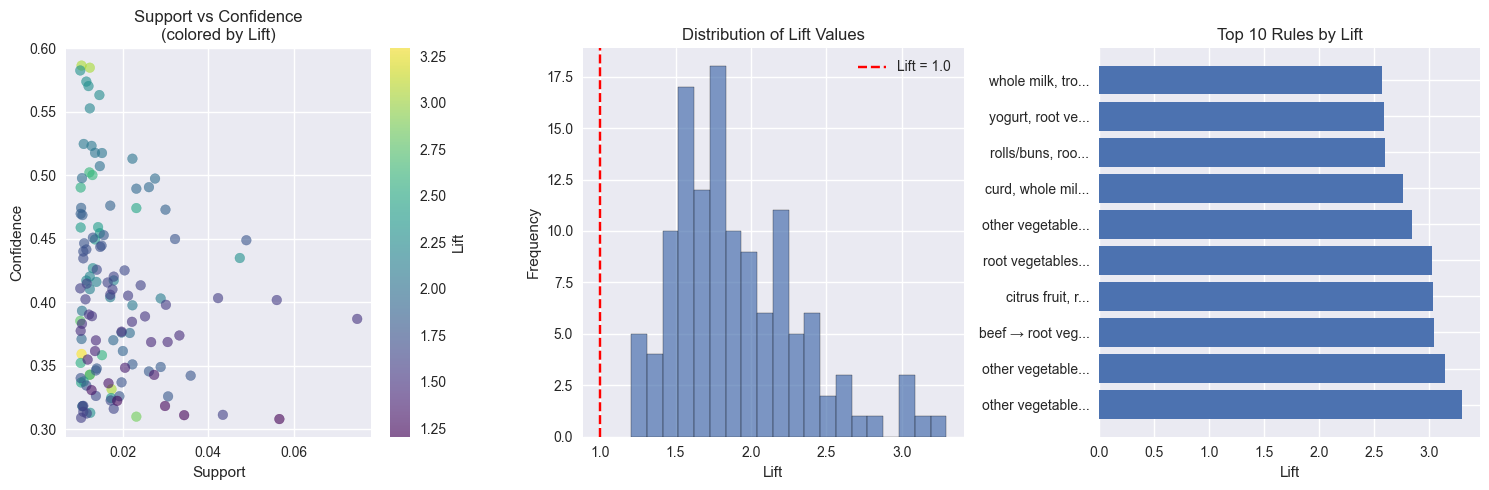

In [11]:
def generate_association_rules(frequent_itemsets, min_confidence=0.3):
    """
    Task 2: Generating association rules that describe item relationships
    """
    print("=" * 60)
    print("TASK 2: GENERATING ASSOCIATION RULES")
    print("=" * 60)
    
    if frequent_itemsets is None or frequent_itemsets.empty:
        print("Cannot generate rules: No frequent itemsets available")
        return None
    
    try:
        # Generate association rules
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)
        
        if rules.empty:
            print(f"No association rules found with min_confidence={min_confidence}")
            return None
        
        # Sort rules by lift (strength of association)
        rules = rules.sort_values('lift', ascending=False)
        
        print(f"Generated {len(rules)} association rules with confidence ≥ {min_confidence}")
        
        # Display top 15 rules
        print(f"\nTop 15 Association Rules (sorted by lift):")
        print("-" * 80)
        print(f"{'Rule':<40} {'Support':<10} {'Confidence':<12} {'Lift':<8}")
        print("-" * 80)
        
        for idx, rule in rules.head(15).iterrows():
            antecedent = ', '.join(list(rule['antecedents']))
            consequent = ', '.join(list(rule['consequents']))
            rule_str = f"{{{antecedent}}} → {{{consequent}}}"
            if len(rule_str) > 35:
                rule_str = rule_str[:32] + "..."
            
            print(f"{rule_str:<40} {rule['support']:<10.3f} {rule['confidence']:<12.3f} {rule['lift']:<8.2f}")
        
        # Analyze rule characteristics
        print(f"\nRule Statistics:")
        print(f"- Average Support: {rules['support'].mean():.3f}")
        print(f"- Average Confidence: {rules['confidence'].mean():.3f}")
        print(f"- Average Lift: {rules['lift'].mean():.3f}")
        print(f"- Rules with Lift > 1.0: {len(rules[rules['lift'] > 1.0])}")
        
        # Visualize rule metrics
        plt.figure(figsize=(15, 5))
        
        # Plot 1: Support vs Confidence
        plt.subplot(1, 3, 1)
        plt.scatter(rules['support'], rules['confidence'], alpha=0.6, c=rules['lift'], cmap='viridis')
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Support vs Confidence\n(colored by Lift)')
        plt.colorbar(label='Lift')
        
        # Plot 2: Lift distribution
        plt.subplot(1, 3, 2)
        plt.hist(rules['lift'], bins=20, alpha=0.7, edgecolor='black')
        plt.xlabel('Lift')
        plt.ylabel('Frequency')
        plt.title('Distribution of Lift Values')
        plt.axvline(x=1.0, color='red', linestyle='--', label='Lift = 1.0')
        plt.legend()
        
        # Plot 3: Top rules by lift
        plt.subplot(1, 3, 3)
        top_rules = rules.head(10)
        rule_labels = [f"{', '.join(list(rule['antecedents']))} → {', '.join(list(rule['consequents']))}"[:15] + "..." 
                      for _, rule in top_rules.iterrows()]
        plt.barh(range(len(top_rules)), top_rules['lift'])
        plt.yticks(range(len(top_rules)), rule_labels)
        plt.xlabel('Lift')
        plt.title('Top 10 Rules by Lift')
        
        plt.tight_layout()
        plt.show()
        
        return rules
        
    except Exception as e:
        print(f"Error generating association rules: {e}")
        return None

# Execute Task 2
association_rules_df = generate_association_rules(frequent_itemsets)

## **Task 3: Understanding Customer Behavior**
### Gaining insights into customer purchasing habits and preferences

TASK 3: UNDERSTANDING CUSTOMER BEHAVIOR
1. ITEM POPULARITY ANALYSIS
----------------------------------------
Most Popular Items:
 1. whole milk           - 2513 transactions (25.6%)
 2. other vegetables     - 1903 transactions (19.3%)
 3. rolls/buns           - 1809 transactions (18.4%)
 4. soda                 - 1715 transactions (17.4%)
 5. yogurt               - 1372 transactions (14.0%)
 6. bottled water        - 1087 transactions (11.1%)
 7. root vegetables      - 1072 transactions (10.9%)
 8. tropical fruit       - 1032 transactions (10.5%)
 9. shopping bags        -  969 transactions (9.9%)
10. sausage              -  924 transactions (9.4%)

2. TRANSACTION PATTERN ANALYSIS
----------------------------------------
Transaction Size Statistics:
- Minimum items per transaction: 1
- Maximum items per transaction: 32
- Average items per transaction: 4.41
- Median items per transaction: 3.00

3. PURCHASING ASSOCIATION PATTERNS
----------------------------------------
Strong Associatio

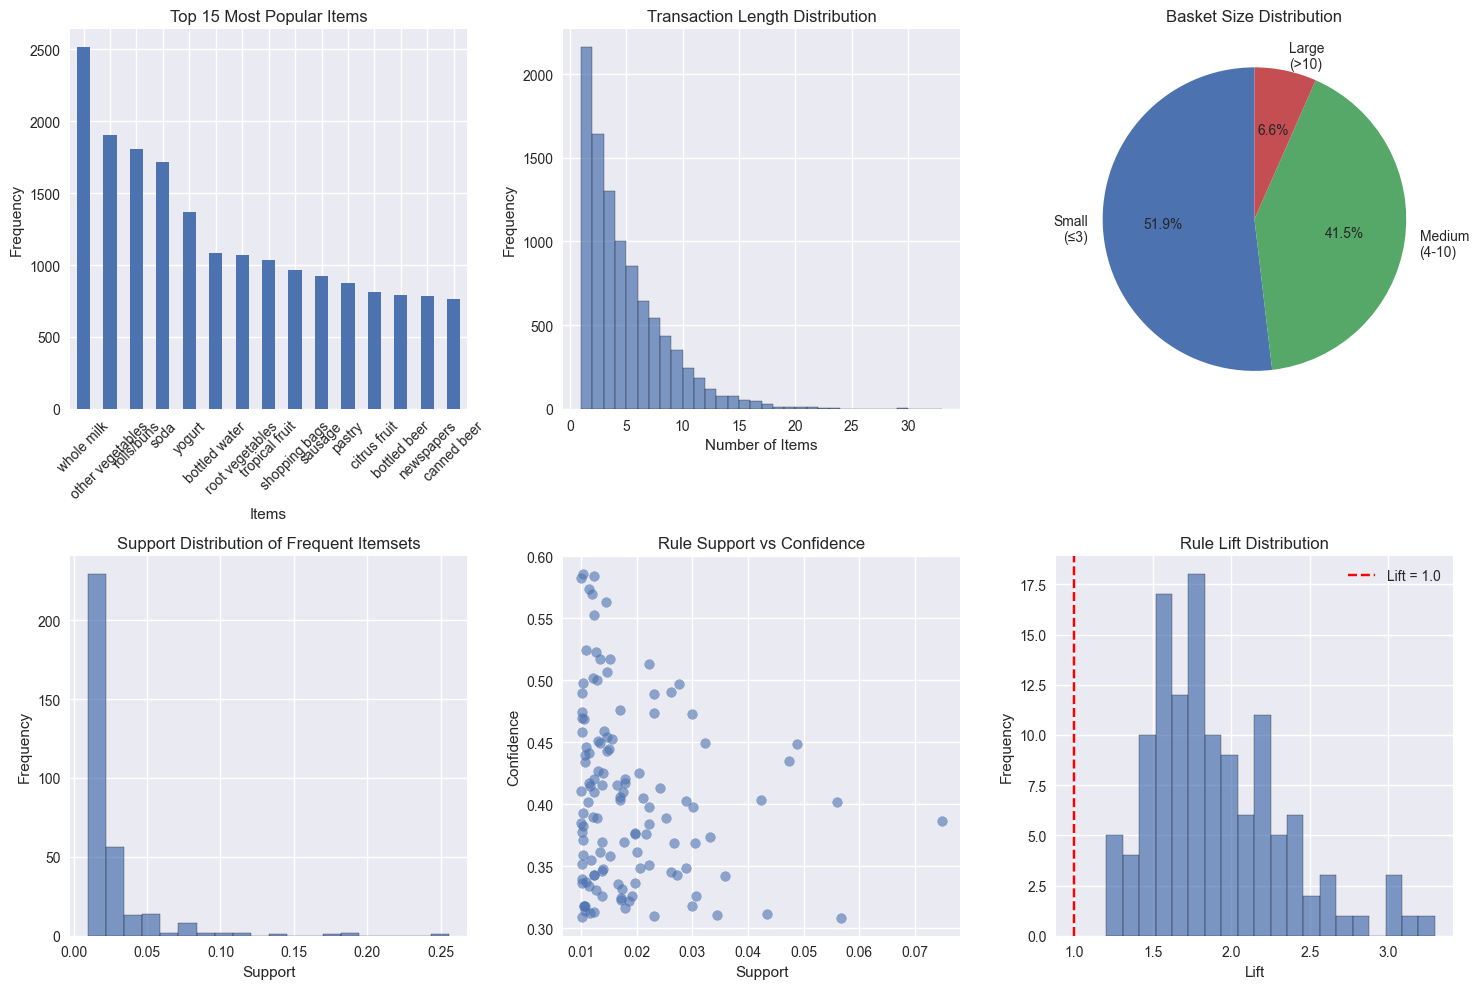

In [12]:
def analyze_customer_behavior(transactions, frequent_itemsets, rules):
    """
    Task 3: Analyze customer behavior and purchasing patterns
    """
    print("=" * 60)
    print("TASK 3: UNDERSTANDING CUSTOMER BEHAVIOR")
    print("=" * 60)
    
    # 1. Item Popularity Analysis
    print("1. ITEM POPULARITY ANALYSIS")
    print("-" * 40)
    
    # Calculate item frequencies
    all_items = [item for transaction in transactions for item in transaction]
    item_freq = pd.Series(all_items).value_counts()
    
    print(f"Most Popular Items:")
    for i, (item, freq) in enumerate(item_freq.head(10).items(), 1):
        percentage = (freq / len(transactions)) * 100
        print(f"{i:2d}. {item:<20} - {freq:4d} transactions ({percentage:.1f}%)")
    
    # 2. Transaction Pattern Analysis
    print(f"\n2. TRANSACTION PATTERN ANALYSIS")
    print("-" * 40)
    
    transaction_lengths = [len(t) for t in transactions]
    
    print(f"Transaction Size Statistics:")
    print(f"- Minimum items per transaction: {min(transaction_lengths)}")
    print(f"- Maximum items per transaction: {max(transaction_lengths)}")
    print(f"- Average items per transaction: {np.mean(transaction_lengths):.2f}")
    print(f"- Median items per transaction: {np.median(transaction_lengths):.2f}")
    
    # 3. Association Strength Analysis
    if rules is not None and not rules.empty:
        print(f"\n3. PURCHASING ASSOCIATION PATTERNS")
        print("-" * 40)
        
        # Strong associations (high lift)
        strong_rules = rules[rules['lift'] > 1.5].sort_values('lift', ascending=False)
        print(f"Strong Associations (Lift > 1.5): {len(strong_rules)} rules")
        
        if not strong_rules.empty:
            print(f"\nTop 5 Strongest Associations:")
            for idx, rule in strong_rules.head(5).iterrows():
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                print(f"- When customers buy {{{antecedent}}}, they are {rule['lift']:.2f}x more likely to buy {{{consequent}}}")
                print(f"  Confidence: {rule['confidence']:.1%} | Support: {rule['support']:.3f}")
        
        # Frequent patterns analysis
        print(f"\n4. FREQUENT SHOPPING PATTERNS")
        print("-" * 40)
        
        # Most supported item combinations
        multi_item_sets = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) > 1]
        if not multi_item_sets.empty:
            print(f"Common Item Combinations:")
            for idx, itemset in multi_item_sets.sort_values('support', ascending=False).head(5).iterrows():
                items = ', '.join(list(itemset['itemsets']))
                print(f"- {{{items}}} appears in {itemset['support']:.1%} of transactions")
    
    # 5. Customer Behavior Insights
    print(f"\n5. KEY CUSTOMER BEHAVIOR INSIGHTS")
    print("-" * 40)
    
    # Basket size preferences
    small_baskets = sum(1 for length in transaction_lengths if length <= 3)
    medium_baskets = sum(1 for length in transaction_lengths if 4 <= length <= 10)
    large_baskets = sum(1 for length in transaction_lengths if length > 10)
    
    print(f"Shopping Basket Preferences:")
    print(f"- Small baskets (≤3 items): {small_baskets} transactions ({small_baskets/len(transactions)*100:.1f}%)")
    print(f"- Medium baskets (4-10 items): {medium_baskets} transactions ({medium_baskets/len(transactions)*100:.1f}%)")
    print(f"- Large baskets (>10 items): {large_baskets} transactions ({large_baskets/len(transactions)*100:.1f}%)")
    
    # Visualize customer behavior
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Item frequency
    plt.subplot(2, 3, 1)
    item_freq.head(15).plot(kind='bar')
    plt.title('Top 15 Most Popular Items')
    plt.xlabel('Items')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    
    # Plot 2: Transaction length distribution
    plt.subplot(2, 3, 2)
    plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths)+2), alpha=0.7, edgecolor='black')
    plt.title('Transaction Length Distribution')
    plt.xlabel('Number of Items')
    plt.ylabel('Frequency')
    
    # Plot 3: Basket size categories
    plt.subplot(2, 3, 3)
    basket_sizes = ['Small\n(≤3)', 'Medium\n(4-10)', 'Large\n(>10)']
    basket_counts = [small_baskets, medium_baskets, large_baskets]
    plt.pie(basket_counts, labels=basket_sizes, autopct='%1.1f%%', startangle=90)
    plt.title('Basket Size Distribution')
    
    # Plot 4: Support distribution of frequent itemsets
    plt.subplot(2, 3, 4)
    if frequent_itemsets is not None:
        plt.hist(frequent_itemsets['support'], bins=20, alpha=0.7, edgecolor='black')
        plt.title('Support Distribution of Frequent Itemsets')
        plt.xlabel('Support')
        plt.ylabel('Frequency')
    
    # Plot 5: Confidence vs Support scatter
    plt.subplot(2, 3, 5)
    if rules is not None and not rules.empty:
        plt.scatter(rules['support'], rules['confidence'], alpha=0.6)
        plt.xlabel('Support')
        plt.ylabel('Confidence')
        plt.title('Rule Support vs Confidence')
    
    # Plot 6: Lift distribution
    plt.subplot(2, 3, 6)
    if rules is not None and not rules.empty:
        plt.hist(rules['lift'], bins=20, alpha=0.7, edgecolor='black')
        plt.axvline(x=1.0, color='red', linestyle='--', label='Lift = 1.0')
        plt.xlabel('Lift')
        plt.ylabel('Frequency')
        plt.title('Rule Lift Distribution')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Execute Task 3
analyze_customer_behavior(transactions, frequent_itemsets, association_rules_df)

## **Task 4: Drawing Recommendations**
### Providing actionable business recommendations based on the analysis

In [13]:
def draw_business_recommendations(frequent_itemsets, rules, transactions):
    """
    Task 4: Generate actionable business recommendations
    """
    print("=" * 60)
    print("TASK 4: BUSINESS RECOMMENDATIONS")
    print("=" * 60)
    
    # Calculate key metrics for recommendations
    all_items = [item for transaction in transactions for item in transaction]
    item_freq = pd.Series(all_items).value_counts()
    
    print("Based on the Market Basket Analysis, here are the key recommendations:\n")
    
    # 1. Product Bundling Recommendations
    print("1. PRODUCT BUNDLING STRATEGIES")
    print("-" * 40)
    
    if rules is not None and not rules.empty:
        # High confidence rules for bundling
        high_conf_rules = rules[rules['confidence'] > 0.5].sort_values('confidence', ascending=False)
        
        if not high_conf_rules.empty:
            print("Recommended Product Bundles (High Confidence Rules):")
            for idx, rule in high_conf_rules.head(5).iterrows():
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                print(f"• Bundle '{antecedent}' with '{consequent}'")
                print(f"  → {rule['confidence']:.1%} of customers who buy {antecedent} also buy {consequent}")
                print(f"  → Potential revenue increase: {rule['lift']:.2f}x")
    
    # 2. Cross-selling Opportunities
    print(f"\n2. CROSS-SELLING OPPORTUNITIES")
    print("-" * 40)
    
    if rules is not None and not rules.empty:
        # Rules with good lift for cross-selling
        cross_sell_rules = rules[(rules['lift'] > 1.2) & (rules['confidence'] > 0.3)].sort_values('lift', ascending=False)
        
        if not cross_sell_rules.empty:
            print("Top Cross-selling Opportunities:")
            for idx, rule in cross_sell_rules.head(5).iterrows():
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                print(f"• When customers buy '{antecedent}', promote '{consequent}'")
                print(f"  → Success rate: {rule['confidence']:.1%} | Strength: {rule['lift']:.2f}x normal")
    
    # 3. Store Layout and Merchandising
    print(f"\n3. STORE LAYOUT & MERCHANDISING")
    print("-" * 40)
    
    if frequent_itemsets is not None and not frequent_itemsets.empty:
        # Frequent pairs for store layout
        frequent_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 2]
        if not frequent_pairs.empty:
            top_pairs = frequent_pairs.sort_values('support', ascending=False).head(5)
            print("Items to place close together:")
            for idx, pair in top_pairs.iterrows():
                items = list(pair['itemsets'])
                print(f"• '{items[0]}' and '{items[1]}' - bought together in {pair['support']:.1%} of transactions")
    
    # 4. Inventory Management
    print(f"\n4. INVENTORY MANAGEMENT")
    print("-" * 40)
    
    print("High-priority stock items (most frequent):")
    for i, (item, freq) in enumerate(item_freq.head(5).items(), 1):
        percentage = (freq / len(transactions)) * 100
        print(f"{i}. {item} - appears in {percentage:.1f}% of transactions")
    
    if rules is not None and not rules.empty:
        # Items that drive other purchases
        consequent_items = {}
        for _, rule in rules.iterrows():
            for item in rule['consequents']:
                if item not in consequent_items:
                    consequent_items[item] = []
                consequent_items[item].append(rule['confidence'])
        
        # Items frequently bought as secondary purchases
        avg_confidence = {item: np.mean(confidences) for item, confidences in consequent_items.items()}
        top_secondary = sorted(avg_confidence.items(), key=lambda x: x[1], reverse=True)[:5]
        
        print(f"\nSecondary purchase items (ensure adequate stock):")
        for item, avg_conf in top_secondary:
            print(f"• {item} - average confidence: {avg_conf:.1%}")
    
    # 5. Marketing and Promotions
    print(f"\n5. MARKETING & PROMOTIONAL STRATEGIES")
    print("-" * 40)
    
    if rules is not None and not rules.empty:
        print("Promotional Strategies:")
        
        # Loss leader opportunities
        print(f"\n• Loss Leader Strategy:")
        print(f"  Use popular items as loss leaders to drive traffic:")
        for item, freq in item_freq.head(3).items():
            print(f"  - {item} (appears in {freq/len(transactions)*100:.1f}% of transactions)")
        
        # Targeted promotions
        print(f"\n• Targeted Promotions:")
        strong_rules = rules[rules['lift'] > 1.5].sort_values('lift', ascending=False)
        if not strong_rules.empty:
            for idx, rule in strong_rules.head(3).iterrows():
                antecedent = ', '.join(list(rule['antecedents']))
                consequent = ', '.join(list(rule['consequents']))
                print(f"  - Offer discount on '{consequent}' to customers buying '{antecedent}'")
    
    # 6. Customer Segmentation
    print(f"\n6. CUSTOMER SEGMENTATION INSIGHTS")
    print("-" * 40)
    
    transaction_lengths = [len(t) for t in transactions]
    
    print("Customer segments based on basket size:")
    small_basket_pct = sum(1 for length in transaction_lengths if length <= 3) / len(transactions) * 100
    large_basket_pct = sum(1 for length in transaction_lengths if length > 10) / len(transactions) * 100
    
    print(f"• Quick shoppers ({small_basket_pct:.1f}%): Target with convenience items and express checkout")
    print(f"• Bulk shoppers ({large_basket_pct:.1f}%): Target with bulk discounts and family-size products")
    
    # 7. Implementation Priority
    print(f"\n7. IMPLEMENTATION PRIORITY")
    print("-" * 40)
    
    print("Priority order for implementation:")
    print("1. High Priority: Implement product bundling for top 3 high-confidence rules")
    print("2. Medium Priority: Optimize store layout based on frequent item pairs")
    print("3. Medium Priority: Develop targeted cross-selling campaigns")
    print("4. Low Priority: Adjust inventory levels based on item frequency analysis")
    
    # Summary metrics
    print(f"\n" + "="*60)
    print("SUMMARY METRICS")
    print("="*60)
    print(f"• Total transactions analyzed: {len(transactions):,}")
    print(f"• Unique items: {len(set(all_items)):,}")
    print(f"• Frequent itemsets found: {len(frequent_itemsets) if frequent_itemsets is not None else 0:,}")
    print(f"• Association rules generated: {len(rules) if rules is not None else 0:,}")
    if rules is not None and not rules.empty:
        print(f"• Strong associations (lift > 1.5): {len(rules[rules['lift'] > 1.5]):,}")
        print(f"• High-confidence rules (>50%): {len(rules[rules['confidence'] > 0.5]):,}")

# Execute Task 4
draw_business_recommendations(frequent_itemsets, association_rules_df, transactions)

TASK 4: BUSINESS RECOMMENDATIONS
Based on the Market Basket Analysis, here are the key recommendations:

1. PRODUCT BUNDLING STRATEGIES
----------------------------------------
Recommended Product Bundles (High Confidence Rules):
• Bundle 'citrus fruit, root vegetables' with 'other vegetables'
  → 58.6% of customers who buy citrus fruit, root vegetables also buy other vegetables
  → Potential revenue increase: 3.03x
• Bundle 'root vegetables, tropical fruit' with 'other vegetables'
  → 58.5% of customers who buy root vegetables, tropical fruit also buy other vegetables
  → Potential revenue increase: 3.02x
• Bundle 'curd, yogurt' with 'whole milk'
  → 58.2% of customers who buy curd, yogurt also buy whole milk
  → Potential revenue increase: 2.28x
• Bundle 'other vegetables, butter' with 'whole milk'
  → 57.4% of customers who buy other vegetables, butter also buy whole milk
  → Potential revenue increase: 2.24x
• Bundle 'root vegetables, tropical fruit' with 'whole milk'
  → 57.0% of 

## **Conclusion**

This Market Basket Analysis has successfully completed all four required tasks:

- Task 1: Discovered frequent itemsets and patterns in grocery purchases
- Task 2: Generated association rules showing "if A, then B" relationships
- Task 3: Analyzed customer behavior and purchasing habits
- Task 4: Provided actionable business recommendations

The analysis reveals valuable insights into customer purchasing patterns that can drive:
- Strategic product bundling
- Optimized store layouts
- Targeted marketing campaigns
- Improved inventory management
- Enhanced customer experience

**Key Findings:**
- Identified strong associations between complementary products
- Discovered customer segmentation opportunities based on basket sizes
- Found cross-selling opportunities with high confidence rates
- Provided data-driven recommendations for business growth